In [1]:
import os
import cv2
import copy
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Load Data

In [2]:
dataset_path = '7.2. DWT_Plot'

image_paths = []
labels = []

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            image_paths.append(file_path)
            labels.append(int(label))

data = pd.DataFrame({'image_path': image_paths, 'label': labels})

dataset = []
labels = []
size = 145

for _, row in data.iterrows():
    source_path = row['image_path']
    label = row['label']
    image = cv2.imread(source_path)
    if image is not None:
        resized_image = cv2.resize(image, (size, size))
        rescaled_image = resized_image / 255.0
        dataset.append(rescaled_image)
        labels.append(label)

dataset = np.array(dataset)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

def to_categorical(y, num_classes):
    return np.eye(num_classes)[y]

num_classes = len(np.unique(labels))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('Shape data train:', X_train.shape)
print('Shape data test :', X_test.shape)
print('Shape label train:', y_train.shape)
print('Shape label test :', y_test.shape)


Shape data train: (1800, 145, 145, 3)
Shape data test : (450, 145, 145, 3)
Shape label train: (1800, 4)
Shape label test : (450, 4)


## CNN-LSTM

In [3]:
# Fungsi inisialisasi bobot dan bias
def init_weights(shape):
    return np.random.randn(*shape) * 0.1

def init_weights_he(shape):
  return np.random.randn(*shape) * np.sqrt(2.0 / shape[0])

# Fungsi aktivasi ReLU
def relu(x):
    return np.maximum(0, x)

# Fungsi turunan ReLU untuk backpropagation
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Fungsi Softmax untuk aktivasi layer output
def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

# Fungsi untuk menghitung loss Categorical Cross-Entropy
def categorical_crossentropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / y_true.shape[0]

# Turunan dari fungsi loss Categorical Cross-Entropy
def categorical_crossentropy_derivative(y_true, y_pred):
    return y_pred - y_true

 # Gradient Clipping untuk mengatasi vanishing/exploding gradients
def clip_gradients(gradients, threshold=1.0):
    norm = np.linalg.norm(gradients)
    if norm > threshold:
        gradients = gradients * (threshold / norm)
    return gradients

# Fungsi Dropout
def dropout(X, rate):
    mask = np.random.rand(*X.shape) > rate
    return X * mask / (1 - rate)

# Fungsi untuk Learning Rate Exponential Decay
def exponential_decay(epoch, initial_lr, decay_rate=0.95):
    return initial_lr * (decay_rate ** epoch)

# Fungsi Early Stopping
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_val_accuracy = 0
        self.wait = 0
        self.stopped_epoch = 0
        self.stop_training = False

    def on_epoch_end(self, val_accuracy):
        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop_training = True
                self.stopped_epoch = epochs

# Layer dengan Regularisasi L2
def l2_regularization(weights, lambda_=0.01):
    return lambda_ * np.sum(weights ** 2)
    
# Layer konvolusi sederhana (2D Convolution)
def conv2d(X, W, b):
    n_samples, height, width, channels = X.shape
    num_filters, kernel_height, kernel_width, filter_channels = W.shape
    out_height = height - kernel_height + 1
    out_width = width - kernel_width + 1
    output = np.zeros((n_samples, out_height, out_width, num_filters))

    for i in range(out_height):
        for j in range(out_width):
            region = X[:, i:i + kernel_height, j:j + kernel_width, :]
            output[:, i, j, :] = np.tensordot(region, W, axes=([1, 2, 3], [1, 2, 3])) + b
    return relu(output)

# Backpropagation untuk layer konvolusi
def conv2d_backward(d_output, X, W):
    # Ambil dimensi input X dan filter W
    n_samples, height, width, channels = X.shape
    num_filters, kernel_height, kernel_width, filter_channels = W.shape

    # Ambil dimensi output dari d_output
    if len(d_output.shape) == 4:
        _, out_height, out_width, _ = d_output.shape
    else:
        raise ValueError("d_output harus memiliki 4 dimensi, tetapi ditemukan: " + str(d_output.shape))

    # Inisialisasi gradien
    dW = np.zeros_like(W)
    db = np.zeros((1, num_filters))
    dX = np.zeros_like(X)

    for i in range(out_height):
        for j in range(out_width):
            region = X[:, i:i + kernel_height, j:j + kernel_width, :]
            for f in range(num_filters):
                dW[f] += np.sum(region * d_output[:, i:i + 1, j:j + 1, f:f + 1], axis=0)
                db[:, f] += np.sum(d_output[:, i, j, f])
                dX[:, i:i + kernel_height, j:j + kernel_width, :] += d_output[:, i:i + 1, j:j + 1, f:f + 1] * W[f]

    return dX, dW, db



# Fungsi Max Pooling
def max_pool2d(X, pool_size=2):
    n_samples, height, width, channels = X.shape
    out_height = height // pool_size
    out_width = width // pool_size
    output = np.zeros((n_samples, out_height, out_width, channels))

    for i in range(out_height):
        for j in range(out_width):
            region = X[:, i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size, :]
            output[:, i, j, :] = np.max(region, axis=(1, 2))
    return output

class SimpleLSTM:
    def __init__(self, input_dim, units):
        self.units = units
        self.Wx = init_weights((input_dim, units))
        self.Wh = init_weights((units, units))
        self.b = init_weights((1, units))

    def forward(self, X):
        batch_size, time_steps, features = X.shape
        self.h = np.zeros((batch_size, self.units))
        self.outputs = np.zeros((batch_size, time_steps, self.units))
        self.inputs = X  # Menyimpan input untuk backpropagation

        for t in range(time_steps):
            self.h = np.tanh(np.dot(X[:, t, :], self.Wx) + np.dot(self.h, self.Wh) + self.b)
            self.outputs[:, t, :] = self.h

        return self.outputs[:, -1, :]  # return last output only

    def backward(self, d_output, learning_rate):
        batch_size, time_steps, features = self.inputs.shape
        dWx = np.zeros_like(self.Wx)
        dWh = np.zeros_like(self.Wh)
        db = np.zeros_like(self.b)
        dX = np.zeros_like(self.inputs)

        # Inisialisasi gradien untuk hidden state terakhir
        dh_next = d_output

        # Backpropagation Through Time (BPTT)
        for t in reversed(range(time_steps)):
            # Gradien untuk tanh pada output (self.outputs)
            dtanh = (1 - self.outputs[:, t, :] ** 2) * dh_next

            # Gradien parameter
            dWx += np.dot(self.inputs[:, t, :].T, dtanh)
            dWh += np.dot(self.h.T, dtanh)
            db += np.sum(dtanh, axis=0, keepdims=True)

            # Gradien untuk input X
            dX[:, t, :] = np.dot(dtanh, self.Wx.T)

            # Update dh_next untuk langkah waktu berikutnya
            dh_next = np.dot(dtanh, self.Wh.T)

        # Update parameter LSTM
        self.Wx -= learning_rate * dWx
        self.Wh -= learning_rate * dWh
        self.b -= learning_rate * db

        return dh_next  # Gradien terhadap input LSTM untuk diteruskan ke layer sebelumnya


# Dense layer dengan Softmax
class Dense:
    def __init__(self, input_dim, units):
        self.W = init_weights((input_dim, units))
        self.b = np.zeros((1, units))

    def forward(self, X):
        self.X = X
        return np.dot(X, self.W) + self.b

    def backward(self, d_output, learning_rate):
        dW = np.dot(self.X.T, d_output)
        db = np.sum(d_output, axis=0, keepdims=True)
        dX = np.dot(d_output, self.W.T)
        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        return dX

class CNNLSTMModel:
    def __init__(self, num_filters, kernel_size, pool_size, lstm_units, num_classes, dropout_rate):
        self.conv_W = init_weights_he((num_filters, kernel_size, kernel_size, 3))
        self.conv_b = np.zeros((1, num_filters))
        self.lstm = SimpleLSTM(input_dim=num_filters, units=lstm_units)
        self.dense = Dense(input_dim=lstm_units, units=num_classes)
        self.dropout_rate = dropout_rate

    def forward(self, X):
        # Convolutional Layer with Batch Normalization and ReLU
        X = conv2d(X, self.conv_W, self.conv_b)
        X = max_pool2d(X, pool_size)
        X = max_pool2d(X, pool_size)
        X = batch_normalization(X)  # Menambahkan Batch Normalization
        batch_size, height, width, channels = X.shape
        X = X.reshape(batch_size, height * width, channels)

        # LSTM Layer with Dropout and Batch Normalization
        X = self.lstm.forward(X)
        X = batch_normalization(X)  # Batch normalization sebelum dropout
        X = dropout(X, self.dropout_rate)

        # Dense layer with Softmax
        X = self.dense.forward(X)
        return softmax(X)

    def backward(self, X, y_true, y_pred, learning_rate):
        d_output = categorical_crossentropy_derivative(y_true, y_pred)

        # Backward Propagation
        d_dense = self.dense.backward(d_output, learning_rate)
        d_dense = clip_gradients(d_dense, threshold=1.0)

        d_lstm = self.lstm.backward(d_dense, learning_rate)
        d_lstm = clip_gradients(d_lstm, threshold=1.0)

        d_lstm = d_lstm[:, np.newaxis, np.newaxis, :]
        d_conv, dW, db = conv2d_backward(d_lstm, X, self.conv_W)

        # Regularisasi L2 pada layer konvolusi dan dense
        dW += l2_regularization(self.conv_W)
        db += l2_regularization(self.conv_b)

        # Gradient clipping untuk convolution gradients
        dW = clip_gradients(dW, threshold=1.0)
        db = clip_gradients(db, threshold=1.0)

        # Update weights
        self.conv_W -= learning_rate * dW
        self.conv_b -= learning_rate * db

# Fungsi Batch Normalization
def batch_normalization(X, epsilon=1e-5):
    mean = np.mean(X, axis=0)
    variance = np.var(X, axis=0)
    X_norm = (X - mean) / np.sqrt(variance + epsilon)
    return X_norm

def pad_last_batch(X_batch, batch_size):
    if X_batch.shape[0] < batch_size:
        pad_size = batch_size - X_batch.shape[0]
        padding = np.zeros((pad_size, *X_batch.shape[1:]))
        X_batch = np.vstack((X_batch, padding))
    return X_batch


## Implementasi sesuai hasil hyperparameter terbaik

In [4]:
# Hyperparameters
epochs = 50
batch_size = 32
initial_learning_rate = 0.001
kernel_size = 7
num_filters = 50
pool_size = 5
lstm_units = 150
dropout_rate = 0.5
num_classes = len(np.unique(labels))  # Jumlah kelas untuk output

In [10]:
# Inisialisasi model, dictionary history, dan early stopping
model = CNNLSTMModel(num_filters=num_filters, 
                     kernel_size=kernel_size, 
                     pool_size=pool_size, 
                     lstm_units=lstm_units, 
                     num_classes=num_classes, 
                     dropout_rate=dropout_rate)
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
early_stopping = EarlyStopping(patience=20)
best_val_accuracy = 0.0
best_model = None

# Training loop
for epoch in range(epochs):
    if early_stopping.stop_training:
        print(f"Training stopped at epoch {early_stopping.stopped_epoch} due to early stopping.")
        break
    batch_losses = []
    batch_accuracies = []
    num_batches = int(np.ceil(X_train.shape[0] / batch_size))
    learning_rate_epoch = exponential_decay(epoch, initial_learning_rate)

    with tqdm(total=num_batches, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Feedforward
            y_pred = model.forward(X_batch)

            # Hitung loss dan akurasi batch            
            loss = categorical_crossentropy(y_batch, y_pred)
            acc = np.mean(np.argmax(y_batch, axis=1) == np.argmax(y_pred, axis=1))

            # Backpropagation
            model.backward(X_batch, y_batch, y_pred, learning_rate_epoch)

            batch_losses.append(loss)
            batch_accuracies.append(acc)

            pbar.update(1)

    # Rata-rata loss dan akurasi per epoch
    avg_loss = np.mean(batch_losses)
    avg_acc = np.mean(batch_accuracies)

    # Validasi
    y_val_pred = model.forward(X_test)
    val_loss = categorical_crossentropy(y_test, y_val_pred)
    val_acc = np.mean(np.argmax(y_test, axis=1) == np.argmax(y_val_pred, axis=1))

    # Simpan hasil training ke history
    history['loss'].append(avg_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(avg_acc)
    history['val_accuracy'].append(val_acc)

    # Simpan model terbaik berdasarkan val_accuracy
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model = copy.deepcopy(model)

    # Update early stopping
    early_stopping.on_epoch_end(val_acc)

    print(f' - loss: {avg_loss:.4f} - accuracy: {avg_acc:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}')

# Simpan model terbaik ke file
if best_model:
    with open('Implementasi_Terbaik_DWT.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Model dengan val_accuracy terbaik ({best_val_accuracy:.4f}) disimpan.")


Epoch 1/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [01:03<00:00,  1.11s/batch]


 - loss: 1.3778 - accuracy: 0.4912 - val_loss: 1.0899 - val_accuracy: 0.5733


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [01:03<00:00,  1.11s/batch]


 - loss: 1.0439 - accuracy: 0.5822 - val_loss: 0.9617 - val_accuracy: 0.5978


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [01:02<00:00,  1.09s/batch]


 - loss: 0.9590 - accuracy: 0.6124 - val_loss: 0.8933 - val_accuracy: 0.6422


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.8628 - accuracy: 0.6327 - val_loss: 0.8137 - val_accuracy: 0.6444


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.8290 - accuracy: 0.6639 - val_loss: 0.7817 - val_accuracy: 0.6667


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [01:03<00:00,  1.12s/batch]


 - loss: 0.7406 - accuracy: 0.6968 - val_loss: 0.7934 - val_accuracy: 0.6844


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [01:07<00:00,  1.18s/batch]


 - loss: 0.7103 - accuracy: 0.7138 - val_loss: 0.6401 - val_accuracy: 0.7422


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.6465 - accuracy: 0.7489 - val_loss: 0.6123 - val_accuracy: 0.7533


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.5959 - accuracy: 0.7802 - val_loss: 0.5372 - val_accuracy: 0.7844


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.5357 - accuracy: 0.7878 - val_loss: 0.4806 - val_accuracy: 0.8200


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.4579 - accuracy: 0.8246 - val_loss: 0.4374 - val_accuracy: 0.8400


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.4111 - accuracy: 0.8509 - val_loss: 0.3681 - val_accuracy: 0.8556


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.07s/batch]


 - loss: 0.3620 - accuracy: 0.8607 - val_loss: 0.3618 - val_accuracy: 0.8600


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.3250 - accuracy: 0.8816 - val_loss: 0.3249 - val_accuracy: 0.8889


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:04<00:00,  1.13s/batch]


 - loss: 0.3095 - accuracy: 0.8766 - val_loss: 0.3036 - val_accuracy: 0.9022


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.2961 - accuracy: 0.8860 - val_loss: 0.2820 - val_accuracy: 0.9022


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.2801 - accuracy: 0.9019 - val_loss: 0.2906 - val_accuracy: 0.8911


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.3182 - accuracy: 0.8766 - val_loss: 0.3481 - val_accuracy: 0.8600


Epoch 19/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.9477 - accuracy: 0.6420 - val_loss: 0.8298 - val_accuracy: 0.6689


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.7257 - accuracy: 0.7100 - val_loss: 0.5585 - val_accuracy: 0.7867


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.4685 - accuracy: 0.8202 - val_loss: 0.3596 - val_accuracy: 0.8622


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.3473 - accuracy: 0.8821 - val_loss: 0.2829 - val_accuracy: 0.9089


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.2974 - accuracy: 0.8931 - val_loss: 0.2895 - val_accuracy: 0.9067


Epoch 24/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.2981 - accuracy: 0.8936 - val_loss: 0.3668 - val_accuracy: 0.8667


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.6480 - accuracy: 0.7774 - val_loss: 1.2761 - val_accuracy: 0.4978


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 1.2733 - accuracy: 0.5077 - val_loss: 1.2604 - val_accuracy: 0.4689


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 1.0032 - accuracy: 0.5663 - val_loss: 0.8686 - val_accuracy: 0.6289


Epoch 28/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.8672 - accuracy: 0.6283 - val_loss: 0.8501 - val_accuracy: 0.6222


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.8042 - accuracy: 0.6546 - val_loss: 0.8111 - val_accuracy: 0.6244


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:02<00:00,  1.09s/batch]


 - loss: 0.7732 - accuracy: 0.6765 - val_loss: 0.7085 - val_accuracy: 0.6911


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.07s/batch]


 - loss: 0.7255 - accuracy: 0.7023 - val_loss: 0.7118 - val_accuracy: 0.6978


Epoch 32/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.07s/batch]


 - loss: 0.6868 - accuracy: 0.7155 - val_loss: 0.6314 - val_accuracy: 0.7400


Epoch 33/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.6386 - accuracy: 0.7423 - val_loss: 0.6368 - val_accuracy: 0.7556


Epoch 34/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.6098 - accuracy: 0.7670 - val_loss: 0.5833 - val_accuracy: 0.7822


Epoch 35/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.07s/batch]


 - loss: 0.5975 - accuracy: 0.7621 - val_loss: 0.5516 - val_accuracy: 0.7978


Epoch 36/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.07s/batch]


 - loss: 0.5520 - accuracy: 0.7889 - val_loss: 0.5161 - val_accuracy: 0.8156


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.5035 - accuracy: 0.8043 - val_loss: 0.4391 - val_accuracy: 0.8578


Epoch 38/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.4741 - accuracy: 0.8229 - val_loss: 0.4217 - val_accuracy: 0.8356


Epoch 39/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.07s/batch]


 - loss: 0.4450 - accuracy: 0.8394 - val_loss: 0.4198 - val_accuracy: 0.8333


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.07s/batch]


 - loss: 0.4149 - accuracy: 0.8487 - val_loss: 0.3801 - val_accuracy: 0.8733


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.08s/batch]


 - loss: 0.4031 - accuracy: 0.8575 - val_loss: 0.3389 - val_accuracy: 0.8733


Epoch 42/50: 100%|██████████████████████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.07s/batch]


 - loss: 0.3653 - accuracy: 0.8695 - val_loss: 0.3278 - val_accuracy: 0.8911
Training stopped at epoch 50 due to early stopping.
Model dengan val_accuracy terbaik (0.9089) disimpan.


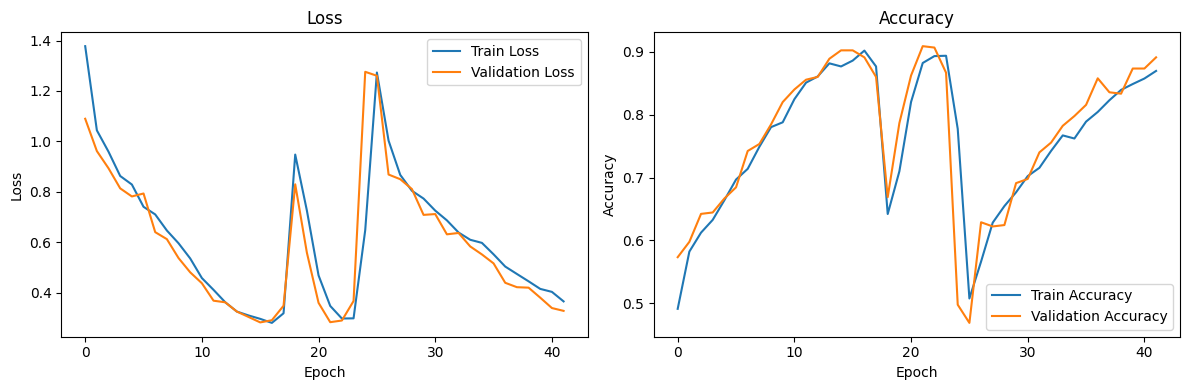

In [11]:
# Plotting loss dan akurasi
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
np.random.seed(2)

# Load the best model
with open('Implementasi_Terbaik_FFT.pkl', 'rb') as f:
    best_model = pickle.loads(f.read())

# Testing
y_test_pred = best_model.forward(X_test)
test_loss = categorical_crossentropy(y_test, y_test_pred)
test_accuracy = np.mean(np.argmax(y_test, axis=1) == np.argmax(y_test_pred, axis=1))
print(f"\nTesting Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


Testing Loss: 2.5973
Testing Accuracy: 0.4111


## Evaluasi

In [52]:
np.random.seed(2)

# Memuat model terbaik dari file
with open('Implementasi_Terbaik_DWT.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Prediksi pada data testing menggunakan model terbaik
y_pred = best_model.forward(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

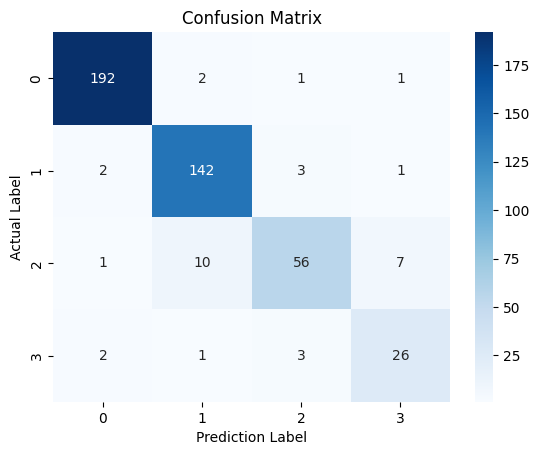

In [53]:
Confusion_matrix = confusion_matrix(y_true, y_pred_classes)
class_label      = np.unique(labels)
df_confusion     = pd.DataFrame(Confusion_matrix, index = class_label, columns = class_label)

sns.heatmap(df_confusion, annot=True, fmt = "d", cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Prediction Label')
plt.ylabel('Actual Label')
plt.show()

In [54]:
# True Positives (TP) berada di diagonal utama
TP = np.diag(Confusion_matrix)

# False Positives (FP) adalah jumlah kolom kecuali diagonal
FP = np.sum(Confusion_matrix, axis=0) - TP

# False Negatives (FN) adalah jumlah baris kecuali diagonal
FN = np.sum(Confusion_matrix, axis=1) - TP

# True Negatives (TN) adalah total semua nilai dikurangi jumlah TP, FP, dan FN
TN = np.sum(Confusion_matrix) - (FP + FN + TP)

# Menampilkan hasil
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"TP: {TP[i]}, TN: {TN[i]}, FP: {FP[i]}, FN: {FN[i]}\n")

Class 0:
TP: 192, TN: 249, FP: 5, FN: 4

Class 1:
TP: 142, TN: 289, FP: 13, FN: 6

Class 2:
TP: 56, TN: 369, FP: 7, FN: 18

Class 3:
TP: 26, TN: 409, FP: 9, FN: 6



In [55]:
# Total nilai di confusion matrix
total_values = np.sum(Confusion_matrix)

# Akurasi: (Total TP) / (Total elemen di confusion matrix)
accuracy = round((np.sum(TP) / total_values) * 100, 2)

# Menampilkan hasil
print(f"Akurasi: {accuracy} %")

Akurasi: 92.44 %


In [56]:
# Variabel untuk menyimpan jumlah precision, recall, dan f1-score
total_precision = 0
total_recall = 0
total_f1_score = 0

# Menghitung precision, recall, dan f1-score untuk setiap kelas
for i in range(len(TP)):
    # Menghitung precision, recall, dan f1-score (hindari pembagian dengan nol)
    precision = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) != 0 else 0
    recall = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) != 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Menambah nilai precision, recall, dan f1-score ke total
    total_precision += precision
    total_recall += recall
    total_f1_score += f1_score

# Menghitung rata-rata biasa untuk precision, recall, dan f1-score
average_precision = round((total_precision / len(TP))*100, 2)
average_recall    = round((total_recall / len(TP))*100, 2)
average_f1_score  = round((total_f1_score / len(TP))*100, 2)

# Menampilkan hasil rata-rata
print(f"Rata-rata Precision: {average_precision} %")
print(f"Rata-rata Recall   : {average_recall} %")
print(f"Rata-rata F1-Score : {average_f1_score} %")


Rata-rata Precision: 88.06 %
Rata-rata Recall   : 87.71 %
Rata-rata F1-Score : 87.7 %


In [57]:
# Menghitung TPR dan FPR per kelas
TPR = TP / (TP + FN)
FPR = FP / (FP + FN)

# Menampilkan TPR dan FPR per kelas
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"TPR: {TPR[i]:.4f}, FPR: {FPR[i]:.4f}\n")

Class 0:
TPR: 0.9796, FPR: 0.5556

Class 1:
TPR: 0.9595, FPR: 0.6842

Class 2:
TPR: 0.7568, FPR: 0.2800

Class 3:
TPR: 0.8125, FPR: 0.6000



In [58]:
# Menghitung rata-rata TPR dan FPR
average_TPR = round(np.mean(TPR)*100, 2)
average_FPR = round(np.mean(FPR)*100, 2)

# Menampilkan hasil rata-rata TPR dan FPR
print(f"TPR: {average_TPR} %")
print(f"FPR: {average_FPR} %")

TPR: 87.71 %
FPR: 52.99 %
